### Demo: train/tune the model and save to Model Catalog

* In this Notebook we will see how to train a sklearn pipeline and save the model to the Model Catalog.
* We will show how to add metadata (reference dataset, metrics..)
* How to deploy the model as a REST service
* Tuning of HP with **ADSTuner**

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import tempfile

import ads
from ads import set_auth

# ADS tuner
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *

# to save to Model Catalog
from ads.catalog.model import ModelCatalog
from ads.model.model_metadata import UseCaseType, MetadataCustomCategory
from ads.model.framework.sklearn_model import SklearnModel


import lightgbm as lgb

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# added to handle with pipelines
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from ads.dataset.factory import DatasetFactory

import logging
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [4]:
# we need ads 2.5.10 or greater
print(ads.__version__)

2.8.0


In [5]:
# set RP
set_auth(auth='resource_principal')

### Prima Parte: preparazione dati

* the dataset is upsampled, to address the imbalance

In [6]:
#
# definisco le funzioni che identificano le categorie di colonne
#
def cat_cols_selector(df, target_name):
    # the input is the dataframe
    
    # cols with less than THR values are considered categoricals
    THR = 10
    
    nunique = df.nunique()
    types = df.dtypes
    
    col_list = []
    
    for col in df.columns:
        if ((types[col] == 'object') or (nunique[col] < THR)):
            # print(col)
            if col != target_name:
                col_list.append(col)
    
    return col_list

def num_cols_selector(df, target_name):
    THR = 10
    
    types = df.dtypes
    nunique = df.nunique()
    
    col_list = []
    
    for col in df.columns:
        if (types[col] != 'object') and (nunique[col] >= THR): 
            # print(col)
            if col != target_name:
                col_list.append(col)
    
    return col_list

def load_as_dataframe(path):
    ds = DatasetFactory.open(path,
                             target="Attrition").set_positive_class('Yes')

    ds_up = ds.up_sample()

    # drop unneeded columns
    cols_to_drop = ['Directs','name', 'Over18','WeeklyWorkedHours','EmployeeNumber']

    ds_used = ds_up.drop(columns=cols_to_drop)
    
    df_used = ds_used.to_pandas_dataframe()

    # train, test split (lo faccio direttamente sui dataframe)
    df_train, df_test = train_test_split(df_used, shuffle=True, test_size=0.2, random_state = 1234)

    print("# of samples in train set", df_train.shape[0])
    print("# of samples in test set", df_test.shape[0])
    
    return df_train, df_test

In [7]:
# load the dataset and do upsampling
TARGET = 'Attrition'

attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

# ritorna un dataset su cui è stato fatto l'upsampling
df_train, df_test = load_as_dataframe(attrition_path)

cat_cols = cat_cols_selector(df_train, TARGET)
num_cols = num_cols_selector(df_train, TARGET)

X_train, y_train = df_train.drop([TARGET], axis=1), df_train[TARGET]
X_test, y_test = df_test.drop([TARGET], axis=1), df_test[TARGET]

# prepare cat_cols for lightgbm
cat_cols_index = [i for i, x in enumerate(X_train.columns) if x in cat_cols]

print()
print(f'Numerical columns: {num_cols} ({len(num_cols)})')
print()
print(f'Categorical columns: {cat_cols} ({len(cat_cols)})')
print()
print("Indexes for cat_cols", cat_cols_index)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

# of samples in train set 1972
# of samples in test set 494

Numerical columns: ['Age', 'SalaryLevel', 'CommuteLength', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'YearsinIndustry', 'YearsOnJob', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion', 'YearsWithCurrManager'] (13)

Categorical columns: ['TravelForWork', 'JobFunction', 'EducationalLevel', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance'] (17)

Indexes for cat_cols [1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 18, 20, 21, 22, 24, 25]


### Definisco la pipeline: trasformazioni + modello

In [8]:
#
# creo la parte Transformers per la pipeline Sklearn
#

# per questo dataset non vi sono missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('standard_scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

In [9]:
#
# definisco la pipeline completa
#
params = {
    # info
    # "verbose" : 0,
    "categorical_feature": cat_cols_index
}

pipe = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', lgb.LGBMClassifier(**params))])

In [10]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer', SimpleImputer()),
                                                   ('standard_scaler',
                                                    StandardScaler())]),
                                   ['Age', 'SalaryLevel', 'CommuteLength',
                                    'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
                                    'NumCompaniesWorked', 'PercentSalaryHike',
                                    'YearsinIndustry', 'YearsOnJob',
                                    'YearsAtCurrentLevel',
                                    'YearsSinceLastPromotion',
                                    'YearsWithCurrManager']),
                                  ('c...
                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                   unknown_value=-

### Tuning iper-parametri con ADS Tuner

In [11]:
scorer = make_scorer(accuracy_score)

In [12]:
tuner = ADSTuner(pipe, cv=3, n_jobs=2, scoring=scorer, random_state=42) ## cv is cross validation splits

tuner.tune(X_train, y_train, exit_criterion=[NTrials(40)])

[I 2023-03-21 11:21:20,578] A new study created in RDB with name: hpo_b68e7c1e-45d1-4e09-b1db-ab6fefe3dc32


In [39]:
tuner.status

<State.COMPLETED: 5>

In [38]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 40


In [40]:
tuner.trials.sort_values(by=["value"], ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_clf__colsample_bytree,params_clf__learning_rate,params_clf__max_depth,params_clf__n_estimators,params_clf__subsample,...,user_attrs_mean_score_time,user_attrs_mean_test_score,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
36,36,0.948278,2023-03-21 11:23:27.314802,2023-03-21 11:23:40.713728,0 days 00:00:13.398926,0.495697,0.314936,5,238,0.713873,...,0.022321,0.948278,accuracy_score,0.943769,0.945205,0.955860,0.051302,0.004529,0.005393,COMPLETE
3,3,0.944723,2023-03-21 11:21:25.757384,2023-03-21 11:21:32.698198,0 days 00:00:06.940814,0.486343,0.341216,4,181,0.621066,...,0.024168,0.944723,accuracy_score,0.951368,0.937595,0.945205,0.027565,0.006346,0.005633,COMPLETE
20,20,0.944219,2023-03-21 11:22:22.837557,2023-03-21 11:22:30.153800,0 days 00:00:07.316243,0.515074,0.381042,5,122,0.804647,...,0.019756,0.944219,accuracy_score,0.943769,0.946728,0.942161,0.022439,0.001114,0.001891,COMPLETE
34,34,0.944219,2023-03-21 11:23:15.847253,2023-03-21 11:23:28.794905,0 days 00:00:12.947652,0.584914,0.321932,5,241,0.719267,...,0.018527,0.944219,accuracy_score,0.945289,0.943683,0.943683,0.068825,0.003851,0.000757,COMPLETE
6,6,0.943714,2023-03-21 11:21:33.664833,2023-03-21 11:21:47.173151,0 days 00:00:13.508318,0.508410,0.386089,5,248,0.639864,...,0.021315,0.943714,accuracy_score,0.939210,0.948250,0.943683,0.095445,0.003471,0.003691,COMPLETE
12,12,0.943204,2023-03-21 11:21:53.929617,2023-03-21 11:22:07.836752,0 days 00:00:13.907135,0.527572,0.324554,5,245,0.614305,...,0.021505,0.943204,accuracy_score,0.945289,0.943683,0.940639,0.037714,0.003876,0.001928,COMPLETE
13,13,0.942702,2023-03-21 11:21:53.930530,2023-03-21 11:22:07.845102,0 days 00:00:13.914572,0.530809,0.319389,5,248,0.607639,...,0.025015,0.942702,accuracy_score,0.934650,0.945205,0.948250,0.060883,0.003408,0.005827,COMPLETE
39,39,0.942697,2023-03-21 11:23:40.733609,2023-03-21 11:23:47.046574,0 days 00:00:06.312965,0.569241,0.309373,5,231,0.789869,...,0.019036,0.942697,accuracy_score,0.943769,0.940639,0.943683,1.604276,0.003780,0.001456,COMPLETE
33,33,0.942193,2023-03-21 11:23:05.021761,2023-03-21 11:23:18.680331,0 days 00:00:13.658570,0.535802,0.326035,5,248,0.629623,...,0.021068,0.942193,accuracy_score,0.937690,0.943683,0.945205,0.001068,0.003083,0.003244,COMPLETE
38,38,0.941685,2023-03-21 11:23:36.246558,2023-03-21 11:23:46.454353,0 days 00:00:10.207795,0.649492,0.347794,5,195,0.787249,...,0.017962,0.941685,accuracy_score,0.939210,0.942161,0.943683,0.210754,0.003853,0.001857,COMPLETE


In [41]:
tuner.best_params

{'colsample_bytree': 0.49569671643293006,
 'learning_rate': 0.3149357360678928,
 'max_depth': 5,
 'n_estimators': 238,
 'subsample': 0.7138726209173323}

### Addestriamo un modello con i migliori parametri (trovati da ADSTuner)

In [42]:
params = tuner.best_params

params["categorical_feature"] = cat_cols_index

pipe = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', lgb.LGBMClassifier(**params))])

In [43]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer', SimpleImputer()),
                                                   ('standard_scaler',
                                                    StandardScaler())]),
                                   ['Age', 'SalaryLevel', 'CommuteLength',
                                    'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
                                    'NumCompaniesWorked', 'PercentSalaryHike',
                                    'YearsinIndustry', 'YearsOnJob',
                                    'YearsAtCurrentLevel',
                                    'YearsSinceLastPromotion',
                                    'YearsWithCurrManager']),
                                  ('c...
                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                   unknown_value=-

In [44]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SalaryLevel',
                                                   'CommuteLength',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'YearsinIndustry',
                  

### Score the Model on the test dataset

In [45]:
# better with categorical features

test_pred = pipe.predict(X_test)
test_probas = pipe.predict_proba(X_test)

print('Validation set result:')

roc_auc = round(roc_auc_score(y_test, test_probas[:,1]), 4)
acc = round(accuracy_score(y_test, test_pred), 4)

# this is the Object that will be saved in the Model Catalog
metrics = {
    "accuracy" : acc,
    "roc_auc" : roc_auc
}

print(str(metrics))

Validation set result:
{'accuracy': 0.9595, 'roc_auc': 0.9968}


### Plot the confusion matrix

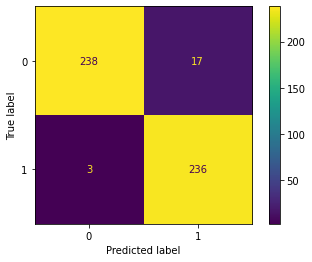

In [46]:
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
plot_cm(pipe, X_test, y_test)

#### Save metrics and model

In [47]:
# save in a file the metrics computed on the reference set
now = datetime.now().strftime('%Y-%m-%d %H:%M')

dict_ref = [{
    "ts_date": now,
    "model_name": "lgb1",
    "algorithm": "lightgbm",
    "accuracy": acc,
    "roc_auc": roc_auc
}]

df_ref = pd.DataFrame(dict_ref)

# save initial file
df_ref.to_csv("model_metrics.csv", index=None)

#### Save model to the Model Catalog

In [48]:
# artifact_dir = tempfile.mkdtemp()
artifact_dir = "model_dir"

# with SklearnModel there is support for pipelines
sklearn_model = SklearnModel(estimator=pipe, artifact_dir= artifact_dir)

In [49]:
# this is the env for runtime, we're using a published conda env
CONDA_ENV = "oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0"

sklearn_model.prepare(
    inference_conda_env=CONDA_ENV,
    training_conda_env=CONDA_ENV,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    as_onnx=False,
    X_sample=X_test,
    y_sample=y_test,
    force_overwrite=True,
)

algorithm: Pipeline
artifact_dir:
  /home/datascience/workshop-july-2022/model_dir:
  - - input_schema.json
    - .model-ignore
    - test_json_output.json
    - model.joblib
    - runtime.yaml
    - score.py
    - output_schema.json
framework: scikit-learn
model_deployment_id: null
model_id: null

In [50]:
%load_ext autoreload
%autoreload 2

sklearn_model.verify(X_test.head(10))

Start loading model.joblib from model directory /home/datascience/workshop-july-2022/model_dir ...
Model is successfully loaded.


{'prediction': [1, 1, 0, 1, 0, 1, 1, 1, 0, 0]}

In [51]:
# compare with expected values
y_test[:10].values

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0])

In [52]:
# add info on reference dataset used for training and on metrics in validation

ref_url = "oci://drift_input@frqap2zhtzbe/reference.csv"

sklearn_model.metadata_custom.add(key='reference dataset', value=ref_url, category=MetadataCustomCategory.TRAINING_AND_VALIDATION_DATASETS, 
                                  description='Reference dataset url. From this dataset have been extracted train/validation dataset', replace=True)

sklearn_model.metadata_custom.add(key='metrics on reference set', value=str(metrics), category=MetadataCustomCategory.PERFORMANCE, 
                                  description='Metrics evaluated on reference dataset', replace=True)

In [53]:
# check all custom metadata
sklearn_model.metadata_custom

data:
- category: Training Environment
  description: The list of files located in artifacts folder.
  key: ModelArtifacts
  value: input_schema.json, .model-ignore, test_json_output.json, model.joblib, runtime.yaml,
    score.py, output_schema.json
- category: Training Profile
  description: The model serialization format.
  key: ModelSerializationFormat
  value: joblib
- category: Training Environment
  description: The URI of the training conda environment.
  key: CondaEnvironmentPath
  value: oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0
- category: Training Environment
  description: The conda environment type, can be published or datascience.
  key: EnvironmentType
  value: published
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: mygeneralml_p37_cpu_v1_0
- category: Other
  description: ''
  key: ClientLibrary
  value: ADS
- category: Training and Va

In [54]:
# save to the Model Catalog

MODEL_NAME = "employee-attr-lgbm-adstuner-dic16"
model_id = sklearn_model.save(display_name=MODEL_NAME)

print(f"Model id in Model Catalog is {model_id}")

Start loading model.joblib from model directory /home/datascience/workshop-july-2022/model_dir ...
Model is successfully loaded.
['input_schema.json', '.model-ignore', 'test_json_output.json', 'model.joblib', 'runtime.yaml', 'score.py', 'output_schema.json']


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

Model id in Model Catalog is ocid1.datasciencemodel.oc1.eu-milan-1.amaaaaaangencdyajp67ufbzpsfwzep4kch43w6dskfc3cnkhvtgghu4rpsa


### Deploy it as a REST service

In [ ]:
sklearn_model.summary_status()

In [ ]:
LOG_GROUP_OCID = "ocid1.loggroup.oc1.eu-milan-1.amaaaaaangencdyagu7uraoiy44qxhvmhiacvmhgftlxbnhdcckigcp5yhxq"
ACCESS_LOG_OCID = "ocid1.log.oc1.eu-milan-1.amaaaaaangencdya4ex76jarx2ub5lodoxftqdomdcgpehtpa2tgqjz2nwpa"
PREDICT_LOG_OCID = "ocid1.log.oc1.eu-milan-1.amaaaaaangencdyaxuovu4gaomizq47qwsh3ofda3wtun5f7jjucncao4x3q"

sklearn_model.deploy(deployment_instance_shape="VM.Standard2.4",
                    display_name="employee-attr-lgbm-adstuner05-ott-deploy2",
                    deployment_instance_count=1,
                    deployment_log_group_id=LOG_GROUP_OCID,
                    deployment_predict_log_id=PREDICT_LOG_OCID,
                    deployment_access_log_id=ACCESS_LOG_OCID)

In [ ]:
sklearn_model.summary_status()